# Import Libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [2]:
from choices import param_dict 
from utilities import deets

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


# Load data

In [3]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

## Cross validation

In [4]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

### Train Classifier One Vs Rest

In [5]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [7]:
gamma = 0.07
cl_weight = calc_weight(gamma , y)
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM' , clf ,gamma , x,y)
model.train()

In [140]:
model.train()
model.save('models/lightGBM-ova.pkl')

In [141]:
import joblib 
model = joblib.load('models/lightGBM-ova.pkl')

## Prediction on New sources

In [152]:
# load model
import joblib
mdoel = joblib.load('models/lightGBM-ova.pkl')
clf = model.clf

In [175]:
# u = []
# ui = []
# for i in range(8):
#     u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
#     ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
# u = pd.concat(u)
# ui = pd.concat(ui)
ui = pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name')
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
u

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J004829.5-732959,2.560959,8.422809,NaN,NaN,2.363359,NaN,9.949403,0.0,3.304254e-09,0.002147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J005449.0-725128,2.525176,8.405124,NaN,NaN,0.900227,NaN,1.221561,0.0,4.201018e-07,0.011944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010049.1-731526,2.548291,8.388764,NaN,NaN,2.694112,NaN,4.333967,0.0,8.611031e-08,0.003832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010049.8-731045,2.543942,8.388578,NaN,NaN,3.098912,NaN,3.680766,0.0,1.742587e-06,0.009243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010647.7-730940,2.544536,8.371916,NaN,NaN,9.693387,NaN,9.994160,6.0,5.241312e-08,0.003135,...,7.329417,3.418280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,2.153631,9.602391,6.284069,0.008090,0.848783,5.00,9.398184,0.0,2.267642e-07,0.035677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220508.3-495935,2.148799,9.600738,7.232708,0.007515,7.897757,6.25,9.373067,2.0,8.028243e-08,0.041673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220544.0-495505,2.142337,9.602388,7.905990,0.007822,NaN,6.25,NaN,NaN,1.863801e-07,0.016260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.034298,0.036080,0.732763,0.000045,0.029809,0.812257,0.002581,0.000045
2CXO J005449.0-725128,0.197113,0.033539,0.810988,0.000002,0.000740,0.205842,0.000102,0.000131
2CXO J010049.1-731526,0.080060,0.028754,0.747214,0.000025,0.034703,0.578318,0.002800,0.000075
2CXO J010049.8-731045,0.170131,0.041141,0.222394,0.000071,0.004165,0.617904,0.000309,0.000167
2CXO J010647.7-730940,0.009535,0.117541,0.725933,0.004263,0.057545,0.377006,0.000015,0.000076
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.086030,0.324645,0.600063,0.000006,0.000044,0.010773,0.001505,0.000296
2CXO J220508.3-495935,0.047244,0.359949,0.635139,0.000075,0.003004,0.006719,0.002030,0.000205
2CXO J220544.0-495505,0.016525,0.049217,0.683977,0.000006,0.000005,0.016902,0.000152,0.000344
2CXO J220555.6-500837,0.005744,0.027714,0.760570,0.000052,0.002039,0.001890,0.500417,0.000108


In [177]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,STAR,0.812257,0.079494,0.034298,0.036080,0.732763,0.000045,0.029809,0.812257,0.002581,0.000045
2CXO J005449.0-725128,HMXB,0.810988,0.605146,0.197113,0.033539,0.810988,0.000002,0.000740,0.205842,0.000102,0.000131
2CXO J010049.1-731526,HMXB,0.747214,0.168896,0.080060,0.028754,0.747214,0.000025,0.034703,0.578318,0.002800,0.000075
2CXO J010049.8-731045,STAR,0.617904,0.395510,0.170131,0.041141,0.222394,0.000071,0.004165,0.617904,0.000309,0.000167
2CXO J010647.7-730940,HMXB,0.725933,0.348927,0.009535,0.117541,0.725933,0.004263,0.057545,0.377006,0.000015,0.000076
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.600063,0.275418,0.086030,0.324645,0.600063,0.000006,0.000044,0.010773,0.001505,0.000296
2CXO J220508.3-495935,HMXB,0.635139,0.275190,0.047244,0.359949,0.635139,0.000075,0.003004,0.006719,0.002030,0.000205
2CXO J220544.0-495505,HMXB,0.683977,0.634760,0.016525,0.049217,0.683977,0.000006,0.000005,0.016902,0.000152,0.000344


In [170]:
#u_df.to_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv')

In [178]:
#u_df = pd.read_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,STAR,0.812257,0.079494,0.034298,0.036080,0.732763,0.000045,0.029809,0.812257,0.002581,0.000045
2CXO J005449.0-725128,HMXB,0.810988,0.605146,0.197113,0.033539,0.810988,0.000002,0.000740,0.205842,0.000102,0.000131
2CXO J010049.1-731526,HMXB,0.747214,0.168896,0.080060,0.028754,0.747214,0.000025,0.034703,0.578318,0.002800,0.000075
2CXO J010049.8-731045,STAR,0.617904,0.395510,0.170131,0.041141,0.222394,0.000071,0.004165,0.617904,0.000309,0.000167
2CXO J010647.7-730940,HMXB,0.725933,0.348927,0.009535,0.117541,0.725933,0.004263,0.057545,0.377006,0.000015,0.000076
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.600063,0.275418,0.086030,0.324645,0.600063,0.000006,0.000044,0.010773,0.001505,0.000296
2CXO J220508.3-495935,HMXB,0.635139,0.275190,0.047244,0.359949,0.635139,0.000075,0.003004,0.006719,0.002030,0.000205
2CXO J220544.0-495505,HMXB,0.683977,0.634760,0.016525,0.049217,0.683977,0.000006,0.000005,0.016902,0.000152,0.000344


In [179]:
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True)
u_pos

,class,prob,ra,dec
name,,,,
2CXO J004829.5-732959,STAR,0.812257,12.123114,-73.499901
2CXO J005449.0-725128,HMXB,0.810988,13.704345,-72.857987
2CXO J010049.1-731526,HMXB,0.747214,15.204787,-73.257463
2CXO J010049.8-731045,STAR,0.617904,15.207831,-73.179381
2CXO J010647.7-730940,HMXB,0.725933,16.699164,-73.161175
...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.600063,331.138121,-49.987838
2CXO J220508.3-495935,HMXB,0.635139,331.284642,-49.993301
2CXO J220544.0-495505,HMXB,0.683977,331.433541,-49.918280


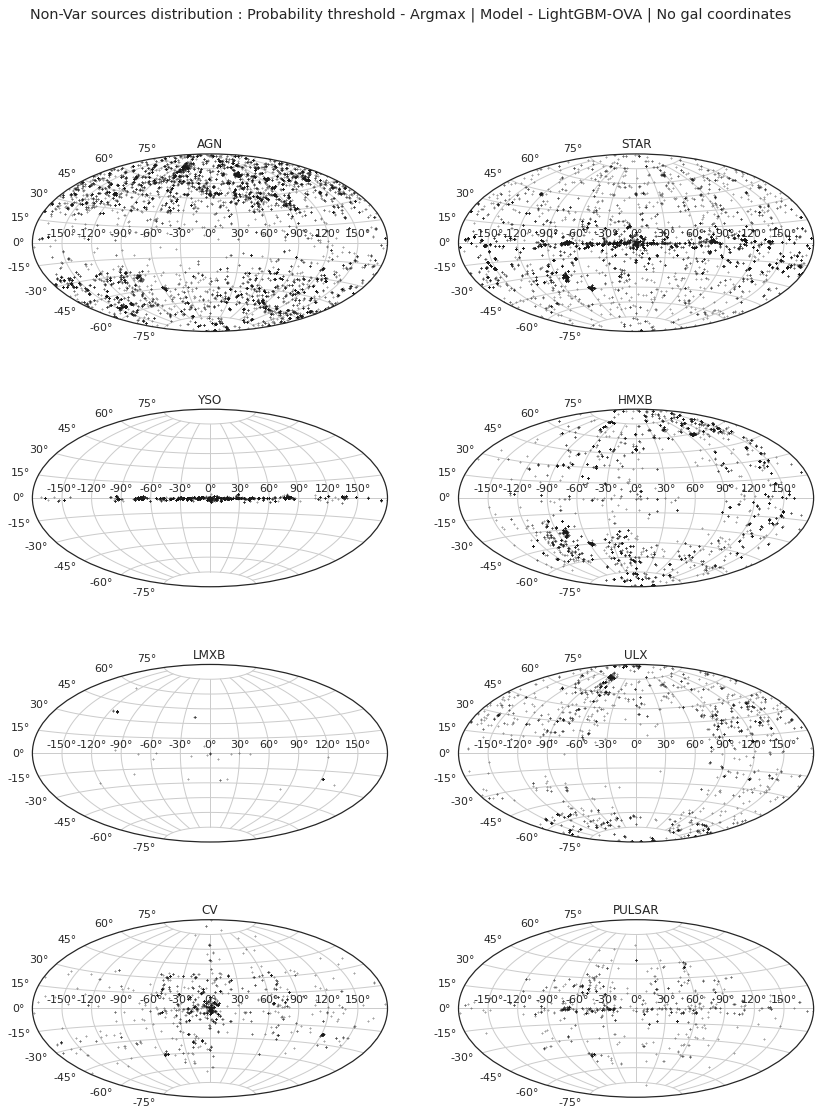

In [180]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
#plt.savefig('plots/all_src_pred/lightgbm_non-var.jpg')
plt.show()

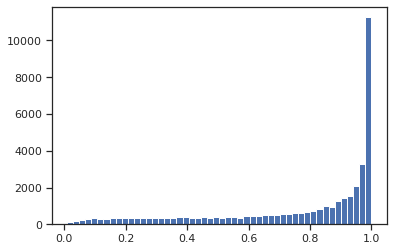

0.980135950990046

In [181]:
x ,y ,z = plt.hist(u_df['prob'] ,bins=50)
plt.grid()
plt.show()
mode = y[np.argmax(x)]
mode

In [182]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                u_df[u_df['prob']>0.6]['class'].value_counts(),
                u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                u_df[u_df['prob']>0.9]['class'].value_counts(),
                u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax' , f"Most probable > {mode :.2f}" ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'0.98']
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   Most probable > 0.98 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |   0.98 |
|:--------|---------:|-----------------------:|------:|------:|------:|------:|------:|-------:|
| STAR    |    10629 |                   4121 |  8774 |  8290 |  7736 |  7032 |  5958 |   4130 |
| AGN     |    10578 |                   2819 |  8235 |  7736 |  7112 |  6286 |  5008 |   2827 |
| YSO     |     9266 |                   3176 |  8709 |  8445 |  8066 |  7420 |  6050 |   3190 |
| HMXB    |     4606 |                    671 |  2907 |  2578 |  2212 |  1816 |  1327 |    673 |
| ULX     |     2161 |                    200 |  1506 |  1317 |  1099 |   868 |   585 |    201 |
| CV      |     1631 |                    104 |   959 |   816 |   670 |   528 |   322 |    104 |
| PULSAR  |      858 |                     46 |   544 |   478 |   402 |   307 |   189 |     46 |
| LMXB    |      164 |                    124 |   140 |   139 |   136 |   132 |   132 |    124 |


In [183]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
#cl.remove('LMXB')
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

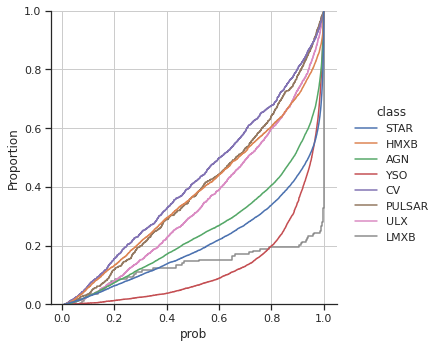

In [184]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()